<a href="https://colab.research.google.com/github/chrisporras/graddiss/blob/dev/Audrey_Copy_of_GradientDissentersHackathon2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon 2023
ML for Biomedical Data Science
Team Gradient Dissenters

Members: Audrey Lee, Christian Porras, Joy Jiang

## Mount Google Drive

For saving and loading models 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
save_models_dir = "/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/"

## Install and load Kaggle mammography

In [3]:
# Clone project git repo
!git clone https://github.com/chrisporras/graddiss.git

Cloning into 'graddiss'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 65 (delta 35), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (65/65), 1.04 MiB | 1.81 MiB/s, done.


In [4]:
# install Kaggle public api
! pip install -q kaggle
# Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
! cp ./graddiss/kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json
#Change the permissions of the file.
! kaggle datasets list

ref                                                           title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                         Spotify and Youtube                             9MB  2023-03-20 15:43:25           1902         75  1.0              
dgoenrique/netflix-movies-and-tv-shows                        Netflix Movies and TV Shows                     2MB  2023-03-13 18:49:00           1284         37  1.0              
rajkumarpandey02/list-of-countries-by-gdp-sector-composition  List of Countries by GDP Sector Composition     8KB  2023-03-20 04:42:10           1249         44  1.0              
datascientistanna/customers-dataset                           Shop Customer Data                    

In [5]:
!kaggle competitions download -c mammography-image-patch-classification-2023

100% 460M/460M [00:21<00:00, 20.4MB/s]
100% 460M/460M [00:21<00:00, 22.4MB/s]


In [6]:
# data directory
!mkdir data
# unzip data there,
!unzip mammography-image-patch-classification-2023.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train_imgs/P000435.png  
  inflating: data/train_imgs/P000436.png  
  inflating: data/train_imgs/P000437.png  
  inflating: data/train_imgs/P000438.png  
  inflating: data/train_imgs/P000439.png  
  inflating: data/train_imgs/P000440.png  
  inflating: data/train_imgs/P000441.png  
  inflating: data/train_imgs/P000442.png  
  inflating: data/train_imgs/P000443.png  
  inflating: data/train_imgs/P000444.png  
  inflating: data/train_imgs/P000445.png  
  inflating: data/train_imgs/P000446.png  
  inflating: data/train_imgs/P000447.png  
  inflating: data/train_imgs/P000448.png  
  inflating: data/train_imgs/P000449.png  
  inflating: data/train_imgs/P000450.png  
  inflating: data/train_imgs/P000451.png  
  inflating: data/train_imgs/P000452.png  
  inflating: data/train_imgs/P000453.png  
  inflating: data/train_imgs/P000454.png  
  inflating: data/train_imgs/P000455.png  
  inflating: data/train_imgs/P000456.png  
  i

## Explore and prepare data

In [7]:
# Configuration class
class Config:
    resize = False
    batch_size = 32
    numworkers = 2

In [8]:
import os
from PIL import Image
import torchvision
from skimage import io, img_as_float32
import numpy as np
import torch
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage import exposure
import cv2

class ToTensor3D(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image):
        image = img_as_float32(image)

        # The following two lines are to duplicate the grayscale image onto
        # 3 channels. That's to make the input compatible with those models
        # trained on color images. If you don't use pretrained models, you can
        # delete these two lines.
        new_shape = (3,) + image.shape
        dup_img = np.broadcast_to(image, new_shape)

        return torch.from_numpy(dup_img.copy())

class CustomImageDataset(torch.utils.data.Dataset):
    """Make a custom dataset for the mammography patches"""  
    def __init__(self, image_dir, df, transform=None, testset=False):
        # Create one iterable that can be __getitemed__
        self.image_dir = image_dir
        self.df = df
        self.transform = transform # added transform
        self.testset = testset # indicates if dataset is the test set

    def __len__(self): # Denotes the total number of samples
        # return self.df.shape[0] # orig
        return len(self.df) # try this

    def normalize(self, image):
      """
      Apply image-level normalization for pre-processing.
      For more background, read here: 
      https://towardsdatascience.com/train-a-neural-network-to-detect-breast-mri-tumors-with-pytorch-250a02be7777
      https://scikit-image.org/docs/stable/user_guide/data_types.html
      https://www.di.ubi.pt/~lfbaa/pubs/recpad2017b.pdf 
      """
      # OLD
      # image = image.astype(float) * 255. / image.max()
      # # Convert float --> uint8. This maps pixel intensities from 0 to 255
      # # Source: above and here: https://scikit-image.org/docs/stable/user_guide/data_types.html
      # image = image.astype(np.uint8)

      # NEW
      # Convert to 8-bit uint (going from [0 to 65535] to [0 to 255])
      # I read the skimage page more closely, where it cautions against using
      # astype. It calls for the below usage instead. These functions convert 
      # images to the desired dtype and properly rescale their values:
      image = img_as_ubyte(image) 

      # Histogram equalization --> poor val acc
      # image = exposure.equalize_hist(image) # skimage implementation
      # image = cv2.equalizeHist(image) # OpenCV implementation

      # Subtract image mean and divide by standard deviation --> poor val acc
      # image_mean = image.mean()
      # image_std = image.std()
      # image = (image - image_mean) / image_std

      return image

    def __getitem__(self, index): # Generates one sample of data
        
        # added this
        if torch.is_tensor(index):
          index = index.tolist()

        # Goes to image_tensor below
        image_path = os.path.join(self.image_dir, self.df.iloc[index]['img_name'])
        # image_og = Image.open(image_path)
        image_og = imread(image_path, as_gray=True) # read in png or jpg

        # Apply image-level normalization for preprocessing
        image = self.normalize(image_og)

        # Convert to 3D tensor
        t = ToTensor3D()
        image = t(image)

        if self.transform:
          image = self.transform(image)
          # image = self.transform(image_og)

        # Since the test set has no label_num, we get the image id
        if not(self.testset):
          label = torch.tensor(self.df.iloc[index]['label_num'],dtype=torch.long)
        else:
          label = self.df.iloc[index]['id'] 

        # # Resize, depending on the network ---> CAN REMOVE
        # if Config.resize:
        #     resize = torchvision.transforms.Resize(384)
        #     image = resize(image)
        
        return image, label

In [9]:
import pandas as pd

# New numeric labels.
labels_num = {'background': 0, 'calc_ben': 1, 'calc_mal': 2, 
              'mass_ben': 3, 'mass_mal': 4}

# Read image metadata
traindf = pd.read_csv('data/train.csv') 
traindf['label_num'] = traindf['label'].map(labels_num)

testdf = pd.read_csv('data/test.csv')

# print(traindf)
# print()
# print(testdf)

In [10]:
# Get how many in each label category
traindf.groupby(["label_num"]).count()

,id,label,img_name
label_num,,,
0,2495,2495,2495
1,1042,1042,1042
2,579,579,579
3,681,681,681
4,637,637,637


Visualize the distribution of the raw data. Notice the class imbalance such that the majority of the data is "background".

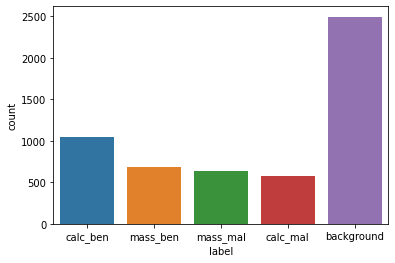

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the different classes
fig, ax = plt.subplots()
ax = sns.countplot(data=traindf,
                   x="label")


In [12]:
# For more ease getting word labels from numerical predictions later
num_labels = {v:k for k,v in labels_num.items()}
num_labels

{0: 'background', 1: 'calc_ben', 2: 'calc_mal', 3: 'mass_ben', 4: 'mass_mal'}

Consider the data augmentation steps we would like to apply to the mammography patches. 

Here are some helpful resources:
*   https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/372567
*   https://www.nature.com/articles/s41598-019-48995-4#Sec2



In [13]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

# First, work with some minimal transforms
initial_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize([0, 0, 0], [1, 1, 1])
      ])

# First, create the original train dataset without transforms
untransformed_train_dataset = CustomImageDataset('data/train_imgs', traindf,
                                                 transform = initial_transforms)
# Create the original val dataset, which is basically a copy of the 
# orig_train_dataset, but with a different set of transformations
untransformed_val_dataset = CustomImageDataset('data/train_imgs', traindf,
                                                 transform = initial_transforms)

# Split the orig_train_dataset into preliminary train and val datasets
train_size = int(0.9 * len(untransformed_train_dataset))
val_size = len(untransformed_train_dataset) - train_size
temp_train_dataset, temp_val_dataset = torch.utils.data.random_split(untransformed_train_dataset, 
                                                     [train_size, val_size])

# Keep track of the indices for each dataset for later
train_indices = temp_train_dataset.indices
val_indices = temp_val_dataset.indices

image_loader = DataLoader(temp_train_dataset, batch_size=Config.batch_size,
                          shuffle=False, num_workers=Config.numworkers)

def batch_mean_and_sd(loader):
    """
    Helper function to get mean and std of dataset using the dataloader.
    See: https://www.google.com/url?q=https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html&sa=D&source=editors&ust=1679883727112650&usg=AOvVaw0FvYMWXTnXnGFI5RooK_pJ
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
train_ds_mean, train_ds_std = batch_mean_and_sd(image_loader)
print("mean and std: \n", train_ds_mean, train_ds_std)

mean and std: 
 tensor([0.3812, 0.3812, 0.3812]) tensor([0.2356, 0.2356, 0.2356])


In [14]:
from torchvision import datasets, transforms

# Define transforms I want to use
data_transforms = {
  "train": transforms.Compose([
      transforms.Resize((224,224)),
      # transforms.Resize(256),
      # transforms.CenterCrop(224),
      # transforms.RandomResizedCrop(224), # Some data augmentation --> get rid of? Seems to get padded areas
      # transforms.Normalize(train_ds_mean, [1., 1., 1.]),
      transforms.RandomHorizontalFlip(), # Some data augmentation
      transforms.RandomVerticalFlip(), # Data augmentation
      transforms.RandomRotation(25), # Data augmentation
      # transforms.Normalize(train_ds_mean, [1., 1., 1.])
      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
      # transforms.RandomAutocontrast(),
      transforms.Normalize(train_ds_mean, train_ds_std)
      ]),

  "val": transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize(train_ds_mean, train_ds_std)
  ]),
  "test": transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize(train_ds_mean, train_ds_std)
  ])
}

Before addressing class imbalance, note how each batch had so much more "background"

In [15]:
# BEFORE ADDRESSING CLASS IMBALANCE
# Make datasets 

# train_dataset = CustomImageDataset('data/train_imgs', traindf, 
#                                    transform=data_transforms["train"])

# train_size = int(0.5 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
#                                                      [train_size, val_size])

# test_dataset = CustomImageDataset('data/test_imgs', testdf)

# # Make dataloaders
# train_loader = torch.utils.data.DataLoader(train_dataset, Config.batch_size, 
#                                            shuffle=True, num_workers=Config.numworkers)

# val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
#                                          shuffle=True, num_workers=Config.numworkers)

# # Build batches - check distribution of classes per batch
# for step, (img,label) in enumerate(train_loader):
#   print("batch index {}, 0/1/2/3/4: {}/{}/{}/{}/{}".format(step,
#                                                            len(np.where(label.numpy() == 0)[0]),
#                                                            len(np.where(label.numpy() == 1)[0]),
#                                                            len(np.where(label.numpy() == 2)[0]),
#                                                            len(np.where(label.numpy() == 3)[0]),
#                                                            len(np.where(label.numpy() == 4)[0]))
#   )

# # Putting these into a dict format for compatibility with the train function later
# dataloaders = {"train": train_loader,
#                "val": val_loader
#                }

# dataset_sizes = {"train": len(train_dataset),
#                  "val": len(val_dataset)
#                  }

### Address class imbalance
We can address class imbalance by creating weights for each class and then doing weighted random sampling.

Side note: I will split the original train set into 90% train and 10% validation. There is a tradeoff between how representative the validation accuracy is and how much data my models can train on.

In [16]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# Want to create separate training and validation datasets, each having their
# own transformations. We also want to prevent leakage!

# First, create the original train dataset
orig_train_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms["train"])
# Create the original val dataset, which is basically a copy of the 
# orig_train_dataset, but with a different set of transformations
orig_val_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms["val"])

# Split the orig_train_dataset into preliminary train and val datasets
# train_size = int(0.9 * len(orig_train_dataset))
# val_size = len(orig_train_dataset) - train_size
# train_dataset, temp_val_dataset = torch.utils.data.random_split(orig_train_dataset, 
#                                                      [train_size, val_size])

# Get the indices for the data that belongs to the temp_val_dataset, and use it 
# to subset the orig_val_dataset. Since we are not shuffling anything, the 
# indices should be the same between train and val.
train_dataset = torch.utils.data.Subset(orig_train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(orig_val_dataset, val_indices)

test_dataset = CustomImageDataset('data/test_imgs', testdf, 
                                  transform=data_transforms["test"],
                                  testset=True)

In [17]:
# Making sure there is no overlap to avoid data leakage into val --> should be False if no overlap
bool(set(val_dataset.indices) & set(train_dataset.indices))

False

In [18]:
# Addressing class imbalance by weighting samples 
# Adjust sample weights within each batch to balance the five classes.
y_train = [orig_train_dataset.df.loc[i]["label_num"] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Remake the train dataloader
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=Config.batch_size,
                          num_workers=Config.numworkers)
val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
                                         shuffle=True, num_workers=Config.numworkers)
test_loader = torch.utils.data.DataLoader(test_dataset, Config.batch_size, 
                                         shuffle=False)
# Can uncomment to see the distribution of each batch
# # Build batches - check distribution of classes per batch
# for step, (img,label) in enumerate(train_loader):
#   print("batch index {}, 0/1/2/3/4: {}/{}/{}/{}/{}".format(step,
#                                                            len(np.where(label.numpy() == 0)[0]),
#                                                            len(np.where(label.numpy() == 1)[0]),
#                                                            len(np.where(label.numpy() == 2)[0]),
#                                                            len(np.where(label.numpy() == 3)[0]),
#                                                            len(np.where(label.numpy() == 4)[0]))
#   )


# Putting these into a dict format for easier use later
dataloaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader
               }

dataset_sizes = {"train": len(train_dataset),
                 "val": len(val_dataset),
                 "test": len(test_dataset)
                 }

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = train_ds_mean.numpy()
    std = train_ds_std.numpy()
    
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


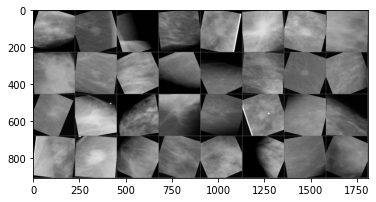

['mass_ben', 'mass_mal', 'background', 'calc_ben', 'calc_ben', 'mass_mal', 'mass_mal', 'calc_mal', 'mass_ben', 'mass_ben', 'calc_mal', 'background', 'background', 'calc_mal', 'mass_mal', 'calc_ben', 'mass_ben', 'mass_mal', 'background', 'mass_mal', 'mass_mal', 'calc_mal', 'calc_ben', 'background', 'calc_mal', 'mass_mal', 'calc_ben', 'mass_ben', 'calc_mal', 'calc_ben', 'mass_ben', 'calc_ben']


In [21]:
import matplotlib.pyplot as plt
from skimage import io, img_as_float32
import numpy as np
import torch

# To get one image:
# temp_img, temp_lab = train_dataset[0]
# print(temp_img.shape)
# imshow(temp_img, title=num_labels[temp_lab.item()])
# plt.title(num_labels[temp_lab.item()])

# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["train"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])
labels_list = [num_labels[x.item()] for x in temp_lab]
print(labels_list)
plt.show()

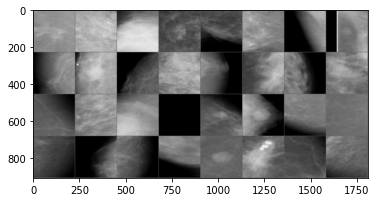

['mass_mal', 'calc_mal', 'calc_ben', 'mass_mal', 'calc_ben', 'calc_ben', 'background', 'mass_ben', 'background', 'mass_mal', 'background', 'calc_ben', 'background', 'calc_ben', 'background', 'calc_mal', 'background', 'calc_ben', 'calc_ben', 'background', 'mass_mal', 'mass_ben', 'calc_ben', 'calc_ben', 'background', 'background', 'background', 'background', 'mass_ben', 'calc_mal', 'calc_ben', 'calc_ben']


In [22]:
# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["val"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])
labels_list = [num_labels[x.item()] for x in temp_lab]
print(labels_list)
plt.show()

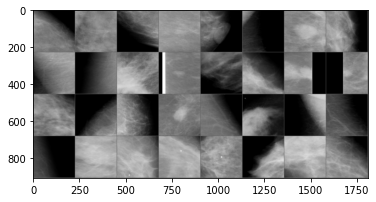

In [23]:
# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["test"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])

plt.show()

## Setting up training functions

Resources:
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [24]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # # For book-keeping the losses and accuracies
    # epoch_ls = []
    # train_loss_ls = []
    # val_loss_ls = []
    # train_acc_ls = []
    # val_acc_ls = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {num_labels[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Try ResNet18

In [ ]:
model_ft = models.resnet18(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1491 Acc: 0.5262
val Loss: 0.7168 Acc: 0.7390

Epoch 1/24
----------
train Loss: 0.8037 Acc: 0.6791
val Loss: 0.5819 Acc: 0.7739

Epoch 2/24
----------
train Loss: 0.6994 Acc: 0.7211
val Loss: 0.5509 Acc: 0.7812

Epoch 3/24
----------
train Loss: 0.6438 Acc: 0.7411
val Loss: 0.7047 Acc: 0.7408

Epoch 4/24
----------
train Loss: 0.6051 Acc: 0.7683
val Loss: 0.5847 Acc: 0.7445

Epoch 5/24
----------
train Loss: 0.5672 Acc: 0.7726
val Loss: 0.5528 Acc: 0.7812

Epoch 6/24
----------
train Loss: 0.5277 Acc: 0.7957
val Loss: 0.5335 Acc: 0.7941

Epoch 7/24
----------
train Loss: 0.4924 Acc: 0.8047
val Loss: 0.5687 Acc: 0.7923

Epoch 8/24
----------
train Loss: 0.4810 Acc: 0.8139
val Loss: 0.5887 Acc: 0.7849

Epoch 9/24
----------
train Loss: 0.4524 Acc: 0.8182
val Loss: 0.7049 Acc: 0.7555

Epoch 10/24
----------
train Loss: 0.3813 Acc: 0.8603
val Loss: 0.5953 Acc: 0.7904

Epoch 11/24
----------
train Loss: 0.3393 Acc: 0.8748
val Loss: 0.5856 Acc: 0.8070

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), save_models_dir+'best_resnet18_dsnormalized.pt')

# Try ResNet50 
Read from bottom up, since most updated model training is higher up.

## Multi-phase training approach with progressive unfreezing of layers
This time with the train dataset mean and std normalization

### Stage 1

In [ ]:
resnet50_model = models.resnet50(weights="DEFAULT")

# Freeze all parameters...except for the final layer
for param in resnet50_model.parameters():
    param.requires_grad = False
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, 5)

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 1.4428 Acc: 0.3798
val Loss: 1.2218 Acc: 0.5551

Epoch 1/2
----------
train Loss: 1.3253 Acc: 0.4564
val Loss: 1.1227 Acc: 0.5938

Epoch 2/2
----------
train Loss: 1.2997 Acc: 0.4693
val Loss: 1.1122 Acc: 0.5846

Training complete in 3m 56s
Best val Acc: 0.593750


### Stage 2

In [ ]:
# For simplicity, first unfreeze all layers
for param in resnet50_model.parameters():
    param.requires_grad = True

In [ ]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
layer_count = 0
for child in resnet50_model.children():
  print("Child ", layer_count)
  print(child)
  children_of_child_counter = 0
  for children_of_child in child.children():
    print("child ", children_of_child_counter, "of child", layer_count)
    print(children_of_child)
    children_of_child_counter += 1 
  layer_count += 1

# print("total layers: ", layer_count)


Child  0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child  1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child  2
ReLU(inplace=True)
Child  3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child  4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d

In [ ]:
# Now selectively freeze layers
child_counter = 0
for child in resnet50_model.children():
  if child_counter < 7:
    print("child", child_counter, "was frozen")
    for param in child.parameters():
      param.requires_grad = False
  elif child_counter == 7:
    children_of_child_counter = 0
    for children_of_child in child.children():
      if children_of_child_counter < 2:
        for param in children_of_child.parameters():
          param.requires_grad = False
        print("child", children_of_child_counter, "of child", child_counter, "was frozen")
      else:
        print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
      children_of_child_counter += 1
  else:
    print("child ",child_counter," was not frozen")
  child_counter += 1
    
    # print("child ",child_counter," was frozen")
    # for param in child.parameters():
    #     param.requires_grad = False

child 0 was frozen
child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 0 of child 7 was frozen
child 1 of child 7 was frozen
child  2 of child 7  was not frozen
child  8  was not frozen
child  9  was not frozen


In [ ]:
resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2400 Acc: 0.5027
val Loss: 1.0105 Acc: 0.6121

Epoch 1/9
----------
train Loss: 1.1617 Acc: 0.5348
val Loss: 0.9577 Acc: 0.6305

Epoch 2/9
----------
train Loss: 1.0836 Acc: 0.5755
val Loss: 0.9667 Acc: 0.6324

Epoch 3/9
----------
train Loss: 1.0556 Acc: 0.5751
val Loss: 0.9546 Acc: 0.6452

Epoch 4/9
----------
train Loss: 1.0134 Acc: 0.5935
val Loss: 0.9142 Acc: 0.6544

Epoch 5/9
----------
train Loss: 0.9982 Acc: 0.6057
val Loss: 0.9168 Acc: 0.6654

Epoch 6/9
----------
train Loss: 0.9940 Acc: 0.6027
val Loss: 0.8705 Acc: 0.6710

Epoch 7/9
----------
train Loss: 0.9592 Acc: 0.6141
val Loss: 0.8723 Acc: 0.6691

Epoch 8/9
----------
train Loss: 0.9457 Acc: 0.6292
val Loss: 0.9059 Acc: 0.6636

Epoch 9/9
----------
train Loss: 0.9269 Acc: 0.6342
val Loss: 0.8671 Acc: 0.6838

Training complete in 12m 52s
Best val Acc: 0.683824


### Stage 3

In [ ]:
# Unfreeze all parameters
for param in resnet50_model.parameters():
    param.requires_grad = True

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=37)

Epoch 0/36
----------
train Loss: 0.9040 Acc: 0.6409
val Loss: 0.8100 Acc: 0.6949

Epoch 1/36
----------
train Loss: 0.8459 Acc: 0.6740
val Loss: 0.8006 Acc: 0.7059

Epoch 2/36
----------
train Loss: 0.8120 Acc: 0.6894
val Loss: 0.7604 Acc: 0.7059

Epoch 3/36
----------
train Loss: 0.7615 Acc: 0.6975
val Loss: 0.7529 Acc: 0.7132

Epoch 4/36
----------
train Loss: 0.7509 Acc: 0.7045
val Loss: 0.7469 Acc: 0.7022

Epoch 5/36
----------
train Loss: 0.7528 Acc: 0.7008
val Loss: 0.7383 Acc: 0.7279

Epoch 6/36
----------
train Loss: 0.7052 Acc: 0.7170
val Loss: 0.7089 Acc: 0.7151

Epoch 7/36
----------
train Loss: 0.7106 Acc: 0.7188
val Loss: 0.6898 Acc: 0.7298

Epoch 8/36
----------
train Loss: 0.6809 Acc: 0.7372
val Loss: 0.6901 Acc: 0.7316

Epoch 9/36
----------
train Loss: 0.6501 Acc: 0.7411
val Loss: 0.6815 Acc: 0.7371

Epoch 10/36
----------
train Loss: 0.6392 Acc: 0.7462
val Loss: 0.6439 Acc: 0.7610

Epoch 11/36
----------
train Loss: 0.6624 Acc: 0.7399
val Loss: 0.6310 Acc: 0.7518

Ep

In [ ]:
# # Save the best model --> checkpoint
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train.pt")

## With new TRAIN DATASET mean std normalization
This time with a lr=0.0005 and more data augmentations (color jitter to 0.5 for each category)

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1033 Acc: 0.5562
val Loss: 0.8630 Acc: 0.7077

Epoch 1/24
----------
train Loss: 0.8391 Acc: 0.6622
val Loss: 0.7262 Acc: 0.7151

Epoch 2/24
----------
train Loss: 0.7800 Acc: 0.6908
val Loss: 0.7016 Acc: 0.7040

Epoch 3/24
----------
train Loss: 0.7539 Acc: 0.6924
val Loss: 0.6687 Acc: 0.7316

Epoch 4/24
----------
train Loss: 0.7034 Acc: 0.7247
val Loss: 0.7680 Acc: 0.7188

Epoch 5/24
----------
train Loss: 0.6718 Acc: 0.7282
val Loss: 0.6052 Acc: 0.7776

Epoch 6/24
----------
train Loss: 0.6419 Acc: 0.7479
val Loss: 0.6500 Acc: 0.7335

Epoch 7/24
----------
train Loss: 0.6513 Acc: 0.7532
val Loss: 0.6859 Acc: 0.7390

Epoch 8/24
----------
train Loss: 0.6411 Acc: 0.7481
val Loss: 0.7589 Acc: 0.7040

Epoch 9/24
----------
train Loss: 0.6036 Acc: 0.7609
val Loss: 0.5714 Acc: 0.7721

Epoch 10/24
----------
train Loss: 0.5174 Acc: 0.7945
val Loss: 0.5133 Acc: 0.7996

Epoch 11/24
----------
train Loss: 0.4837 Acc: 0.8131
val Loss: 0.4997 Acc: 0.8051

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), save_models_dir+'best_resnet50_dsnormalized_lrincr.pt')

## With new TRAIN DATASET mean normalization

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1826 Acc: 0.5202
val Loss: 1.0616 Acc: 0.5772

Epoch 1/24
----------
train Loss: 0.7851 Acc: 0.6888
val Loss: 0.6980 Acc: 0.7426

Epoch 2/24
----------
train Loss: 0.6684 Acc: 0.7452
val Loss: 0.6124 Acc: 0.7812

Epoch 3/24
----------
train Loss: 0.5870 Acc: 0.7738
val Loss: 0.5333 Acc: 0.7868

Epoch 4/24
----------
train Loss: 0.5150 Acc: 0.8000
val Loss: 0.5526 Acc: 0.7923

Epoch 5/24
----------
train Loss: 0.4908 Acc: 0.8108
val Loss: 0.5422 Acc: 0.8033

Epoch 6/24
----------
train Loss: 0.4396 Acc: 0.8339
val Loss: 0.5662 Acc: 0.8051

Epoch 7/24
----------
train Loss: 0.4009 Acc: 0.8521
val Loss: 0.5773 Acc: 0.7996

Epoch 8/24
----------
train Loss: 0.3619 Acc: 0.8685
val Loss: 0.6310 Acc: 0.7941

Epoch 9/24
----------
train Loss: 0.3312 Acc: 0.8771
val Loss: 0.6939 Acc: 0.7739

Epoch 10/24
----------
train Loss: 0.2790 Acc: 0.8986
val Loss: 0.6020 Acc: 0.7996

Epoch 11/24
----------
train Loss: 0.2340 Acc: 0.9129
val Loss: 0.6185 Acc: 0.8033

Ep

In [ ]:
# Save the best model
# torch.save(model_ft.state_dict(), save_models_dir+'best_resnet50_dsnormalized.pt')

## With new TRAIN DATASET mean std normalization

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1656 Acc: 0.5258
val Loss: 0.7556 Acc: 0.7114

Epoch 1/24
----------
train Loss: 0.7769 Acc: 0.6973
val Loss: 0.6883 Acc: 0.7316

Epoch 2/24
----------
train Loss: 0.6561 Acc: 0.7429
val Loss: 0.5570 Acc: 0.7941

Epoch 3/24
----------
train Loss: 0.6004 Acc: 0.7708
val Loss: 0.6406 Acc: 0.7721

Epoch 4/24
----------
train Loss: 0.5430 Acc: 0.7894
val Loss: 0.5426 Acc: 0.7960

Epoch 5/24
----------
train Loss: 0.4911 Acc: 0.8176
val Loss: 0.5044 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.4539 Acc: 0.8241
val Loss: 0.5849 Acc: 0.7923

Epoch 7/24
----------
train Loss: 0.4015 Acc: 0.8458
val Loss: 0.5712 Acc: 0.8180

Epoch 8/24
----------
train Loss: 0.3660 Acc: 0.8640
val Loss: 0.5592 Acc: 0.7996

Epoch 9/24
----------
train Loss: 0.3550 Acc: 0.8691
val Loss: 0.6329 Acc: 0.8125

Epoch 10/24
----------
train Loss: 0.2929 Acc: 0.8918
val Loss: 0.5708 Acc: 0.8199

Epoch 11/24
----------
train Loss: 0.2454 Acc: 0.9106
val Loss: 0.5734 Acc: 0.8162

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), save_models_dir+'best_resnet50_dsnormalized.pt')

## With new mean std normalization (normalization)

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2847 Acc: 0.4569
val Loss: 45.1800 Acc: 0.4062

Epoch 1/24
----------
train Loss: 1.0325 Acc: 0.5775
val Loss: 200.1276 Acc: 0.1544

Epoch 2/24
----------
train Loss: 0.9124 Acc: 0.6387
val Loss: 231.5662 Acc: 0.1471

Epoch 3/24
----------
train Loss: 0.8290 Acc: 0.6597
val Loss: 264.4141 Acc: 0.1415

Epoch 4/24
----------
train Loss: 0.7677 Acc: 0.6894
val Loss: 399.3575 Acc: 0.1415

Epoch 5/24
----------
train Loss: 0.6958 Acc: 0.7241
val Loss: 1182.9205 Acc: 0.1379

Epoch 6/24
----------
train Loss: 0.6594 Acc: 0.7442
val Loss: 277.2120 Acc: 0.2169

Epoch 7/24
----------
train Loss: 0.6028 Acc: 0.7714
val Loss: 512.3234 Acc: 0.4669

Epoch 8/24
----------
train Loss: 0.5748 Acc: 0.7777
val Loss: 646.2720 Acc: 0.4026

Epoch 9/24
----------
train Loss: 0.5103 Acc: 0.8055
val Loss: 1529.5891 Acc: 0.1397

Epoch 10/24
----------
train Loss: 0.4530 Acc: 0.8307
val Loss: 1500.4126 Acc: 0.1397

Epoch 11/24
----------
train Loss: 0.3966 Acc: 0.8566
val Loss

KeyboardInterrupt: ignored

In [ ]:
# # Save the best model
# torch.save(model_ft.state_dict(), save_models_dir+'best_resnet50_equalhist.pt')

## With new histogram equalization (normalization)

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2436 Acc: 0.4663
val Loss: 0.9684 Acc: 0.6121

Epoch 1/24
----------
train Loss: 0.9368 Acc: 0.6305
val Loss: 0.8178 Acc: 0.6820

Epoch 2/24
----------
train Loss: 0.8315 Acc: 0.6693
val Loss: 0.7916 Acc: 0.6838

Epoch 3/24
----------
train Loss: 0.7551 Acc: 0.7041
val Loss: 0.7108 Acc: 0.7151

Epoch 4/24
----------
train Loss: 0.6817 Acc: 0.7335
val Loss: 0.6228 Acc: 0.7647

Epoch 5/24
----------
train Loss: 0.6406 Acc: 0.7474
val Loss: 0.7299 Acc: 0.7298

Epoch 6/24
----------
train Loss: 0.5604 Acc: 0.7869
val Loss: 0.7191 Acc: 0.7500

Epoch 7/24
----------
train Loss: 0.5231 Acc: 0.7988
val Loss: 0.6833 Acc: 0.7500

Epoch 8/24
----------
train Loss: 0.5019 Acc: 0.8127
val Loss: 0.7136 Acc: 0.7555

Epoch 9/24
----------
train Loss: 0.4617 Acc: 0.8243
val Loss: 0.7582 Acc: 0.7482

Epoch 10/24
----------
train Loss: 0.3729 Acc: 0.8626
val Loss: 0.7297 Acc: 0.7500

Epoch 11/24
----------
train Loss: 0.3574 Acc: 0.8724
val Loss: 0.7190 Acc: 0.7500

Ep

In [ ]:
# # Save the best model
# torch.save(model_ft.state_dict(), save_models_dir+'best_resnet50_equalhist.pt')

## Multi-phase training approach with progressive unfreezing of layers

### Stage 1

In [ ]:
resnet50_model = models.resnet50(weights="DEFAULT")

# Freeze all parameters...except for the final layer
for param in resnet50_model.parameters():
    param.requires_grad = False
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, 5)

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 1.4431 Acc: 0.3933
val Loss: 1.2371 Acc: 0.5368

Epoch 1/2
----------
train Loss: 1.3161 Acc: 0.4605
val Loss: 1.1856 Acc: 0.5312

Epoch 2/2
----------
train Loss: 1.2868 Acc: 0.4769
val Loss: 1.1716 Acc: 0.5441

Training complete in 4m 4s
Best val Acc: 0.544118


### Stage 2

In [ ]:
# For simplicity, first unfreeze all layers
for param in resnet50_model.parameters():
    param.requires_grad = True

In [ ]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
layer_count = 0
for child in resnet50_model.children():
  print("Child ", layer_count)
  print(child)
  children_of_child_counter = 0
  for children_of_child in child.children():
    print("child ", children_of_child_counter, "of child", layer_count)
    print(children_of_child)
    children_of_child_counter += 1 
  layer_count += 1

# print("total layers: ", layer_count)


Child  0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child  1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child  2
ReLU(inplace=True)
Child  3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child  4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d

In [ ]:
# Now selectively freeze layers
child_counter = 0
for child in resnet50_model.children():
  if child_counter < 7:
    print("child", child_counter, "was frozen")
    for param in child.parameters():
      param.requires_grad = False
  elif child_counter == 7:
    children_of_child_counter = 0
    for children_of_child in child.children():
      if children_of_child_counter < 2:
        for param in children_of_child.parameters():
          param.requires_grad = False
        print("child", children_of_child_counter, "of child", child_counter, "was frozen")
      else:
        print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
      children_of_child_counter += 1
  else:
    print("child ",child_counter," was not frozen")
  child_counter += 1
    
    # print("child ",child_counter," was frozen")
    # for param in child.parameters():
    #     param.requires_grad = False

child 0 was frozen
child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 0 of child 7 was frozen
child 1 of child 7 was frozen
child  2 of child 7  was not frozen
child  8  was not frozen
child  9  was not frozen


In [ ]:
resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.1914 Acc: 0.5307
val Loss: 1.0674 Acc: 0.5827

Epoch 1/9
----------
train Loss: 1.1433 Acc: 0.5366
val Loss: 1.0331 Acc: 0.6066

Epoch 2/9
----------
train Loss: 1.1083 Acc: 0.5487
val Loss: 1.0304 Acc: 0.5974

Epoch 3/9
----------
train Loss: 1.0801 Acc: 0.5579
val Loss: 1.0193 Acc: 0.6268

Epoch 4/9
----------
train Loss: 1.0202 Acc: 0.5849
val Loss: 0.9306 Acc: 0.6287

Epoch 5/9
----------
train Loss: 1.0037 Acc: 0.5988
val Loss: 0.9270 Acc: 0.6232

Epoch 6/9
----------
train Loss: 0.9851 Acc: 0.6092
val Loss: 0.9268 Acc: 0.6268

Epoch 7/9
----------
train Loss: 0.9685 Acc: 0.6172
val Loss: 0.9372 Acc: 0.6397

Epoch 8/9
----------
train Loss: 0.9616 Acc: 0.6125
val Loss: 0.9039 Acc: 0.6489

Epoch 9/9
----------
train Loss: 0.9448 Acc: 0.6258
val Loss: 0.9171 Acc: 0.6305

Training complete in 13m 9s
Best val Acc: 0.648897


### Stage 3

In [ ]:
# Unfreeze all parameters
for param in resnet50_model.parameters():
    param.requires_grad = True

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=37)

Epoch 0/36
----------
train Loss: 0.8716 Acc: 0.6532
val Loss: 0.8317 Acc: 0.6599

Epoch 1/36
----------
train Loss: 0.8595 Acc: 0.6679
val Loss: 0.8484 Acc: 0.6673

Epoch 2/36
----------
train Loss: 0.8024 Acc: 0.6828
val Loss: 0.7976 Acc: 0.6746

Epoch 3/36
----------
train Loss: 0.7816 Acc: 0.6883
val Loss: 0.7721 Acc: 0.7096

Epoch 4/36
----------
train Loss: 0.7671 Acc: 0.7006
val Loss: 0.7608 Acc: 0.7132

Epoch 5/36
----------
train Loss: 0.7522 Acc: 0.7004
val Loss: 0.7432 Acc: 0.7224

Epoch 6/36
----------
train Loss: 0.7281 Acc: 0.7178
val Loss: 0.7183 Acc: 0.7298

Epoch 7/36
----------
train Loss: 0.7030 Acc: 0.7160
val Loss: 0.7336 Acc: 0.7206

Epoch 8/36
----------
train Loss: 0.6744 Acc: 0.7399
val Loss: 0.7237 Acc: 0.7371

Epoch 9/36
----------
train Loss: 0.7010 Acc: 0.7219
val Loss: 0.7185 Acc: 0.7316

Epoch 10/36
----------
train Loss: 0.6352 Acc: 0.7452
val Loss: 0.7222 Acc: 0.7279

Epoch 11/36
----------
train Loss: 0.6518 Acc: 0.7454
val Loss: 0.7224 Acc: 0.7298

Ep

In [ ]:
# Save the best model --> checkpoint
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train.pt")

Continue with the above, so going to 100 epochs

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4078 Acc: 0.8476
val Loss: 0.6840 Acc: 0.7586

Epoch 1/49
----------
train Loss: 0.3722 Acc: 0.8627
val Loss: 0.6709 Acc: 0.7622

Epoch 2/49
----------
train Loss: 0.3637 Acc: 0.8668
val Loss: 0.6854 Acc: 0.7611

Epoch 3/49
----------
train Loss: 0.3626 Acc: 0.8653
val Loss: 0.6646 Acc: 0.7648

Epoch 4/49
----------
train Loss: 0.3472 Acc: 0.8800
val Loss: 0.6832 Acc: 0.7670

Epoch 5/49
----------
train Loss: 0.3416 Acc: 0.8734
val Loss: 0.6845 Acc: 0.7644

Epoch 6/49
----------
train Loss: 0.3365 Acc: 0.8763
val Loss: 0.7069 Acc: 0.7667

Epoch 7/49
----------
train Loss: 0.3579 Acc: 0.8671
val Loss: 0.6753 Acc: 0.7696

Epoch 8/49
----------
train Loss: 0.3174 Acc: 0.8837
val Loss: 0.7006 Acc: 0.7637

Epoch 9/49
----------
train Loss: 0.3093 Acc: 0.8929
val Loss: 0.6888 Acc: 0.7755

Epoch 10/49
----------
train Loss: 0.2931 Acc: 0.8914
val Loss: 0.7001 Acc: 0.7648

Epoch 11/49
----------
train Loss: 0.2829 Acc: 0.8966
val Loss: 0.7060 Acc: 0.7703

Ep

In [ ]:
# Save the best model --> checkpoint
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train.pt")

Keep...going...(150 epochs)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.2426 Acc: 0.9172
val Loss: 0.7228 Acc: 0.7670

Epoch 1/49
----------
train Loss: 0.2324 Acc: 0.9216
val Loss: 0.7220 Acc: 0.7692

Epoch 2/49
----------
train Loss: 0.2195 Acc: 0.9264
val Loss: 0.7093 Acc: 0.7784

Epoch 3/49
----------
train Loss: 0.2277 Acc: 0.9124
val Loss: 0.7207 Acc: 0.7751

Epoch 4/49
----------
train Loss: 0.2209 Acc: 0.9268
val Loss: 0.7239 Acc: 0.7652

Epoch 5/49
----------
train Loss: 0.2331 Acc: 0.9220
val Loss: 0.7302 Acc: 0.7644

Epoch 6/49
----------
train Loss: 0.2514 Acc: 0.9084
val Loss: 0.7318 Acc: 0.7736

Epoch 7/49
----------
train Loss: 0.2234 Acc: 0.9234
val Loss: 0.7202 Acc: 0.7722

Epoch 8/49
----------
train Loss: 0.2176 Acc: 0.9290
val Loss: 0.7201 Acc: 0.7736

Epoch 9/49
----------
train Loss: 0.2315 Acc: 0.9183
val Loss: 0.7291 Acc: 0.7703

Epoch 10/49
----------
train Loss: 0.2199 Acc: 0.9279
val Loss: 0.7208 Acc: 0.7788

Epoch 11/49
----------
train Loss: 0.2391 Acc: 0.9165
val Loss: 0.7119 Acc: 0.7751

Ep

Is it possible to pop out of a local minima?

In [ ]:
# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4094 Acc: 0.8439
val Loss: 0.8726 Acc: 0.7114

Epoch 1/24
----------
train Loss: 0.4034 Acc: 0.8506
val Loss: 0.7413 Acc: 0.7460

Epoch 2/24
----------
train Loss: 0.3636 Acc: 0.8690
val Loss: 0.8714 Acc: 0.7111

Epoch 3/24
----------
train Loss: 0.3238 Acc: 0.8815
val Loss: 0.7631 Acc: 0.7512

Epoch 4/24
----------
train Loss: 0.2946 Acc: 0.8881
val Loss: 0.8012 Acc: 0.7563

Epoch 5/24
----------
train Loss: 0.2676 Acc: 0.9021
val Loss: 0.8877 Acc: 0.7446

Epoch 6/24
----------
train Loss: 0.2777 Acc: 0.9017
val Loss: 0.7746 Acc: 0.7575

Epoch 7/24
----------
train Loss: 0.2391 Acc: 0.9131
val Loss: 0.8625 Acc: 0.7332

Epoch 8/24
----------
train Loss: 0.2177 Acc: 0.9172
val Loss: 0.8090 Acc: 0.7644

Epoch 9/24
----------
train Loss: 0.2020 Acc: 0.9257
val Loss: 0.8628 Acc: 0.7468

Epoch 10/24
----------
train Loss: 0.1783 Acc: 0.9341
val Loss: 0.8273 Acc: 0.7711

Epoch 11/24
----------
train Loss: 0.1846 Acc: 0.9356
val Loss: 0.8500 Acc: 0.7589

Ep

In [ ]:
# Save the best model
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train_incrLRlate.pt")

## Train 90%, val 10%

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.2134 Acc: 0.5012
val Loss: 0.9849 Acc: 0.6379

Epoch 1/49
----------
train Loss: 0.7908 Acc: 0.6814
val Loss: 0.6718 Acc: 0.7592

Epoch 2/49
----------
train Loss: 0.6592 Acc: 0.7354
val Loss: 0.6610 Acc: 0.7629

Epoch 3/49
----------
train Loss: 0.5832 Acc: 0.7712
val Loss: 0.6563 Acc: 0.7574

Epoch 4/49
----------
train Loss: 0.5543 Acc: 0.7791
val Loss: 0.5824 Acc: 0.7684

Epoch 5/49
----------
train Loss: 0.5193 Acc: 0.7957
val Loss: 0.5410 Acc: 0.7849

Epoch 6/49
----------
train Loss: 0.4593 Acc: 0.8188
val Loss: 0.5653 Acc: 0.7886

Epoch 7/49
----------
train Loss: 0.4298 Acc: 0.8370
val Loss: 0.5994 Acc: 0.7757

Epoch 8/49
----------
train Loss: 0.3819 Acc: 0.8497
val Loss: 0.6744 Acc: 0.7776

Epoch 9/49
----------
train Loss: 0.3541 Acc: 0.8693
val Loss: 0.6198 Acc: 0.7904

Epoch 10/49
----------
train Loss: 0.3317 Acc: 0.8810
val Loss: 0.6081 Acc: 0.7960

Epoch 11/49
----------
train Loss: 0.3025 Acc: 0.8869
val Loss: 0.5990 Acc: 0.7978

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_AdamOptim.pt')

## Multi-phase training approach with progressive unfreezing of layers

### Stage 1

In [ ]:
resnet50_model = models.resnet50(weights="DEFAULT")

# Freeze all parameters...except for the final layer
for param in resnet50_model.parameters():
    param.requires_grad = False
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, 5)

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 1.4885 Acc: 0.3636
val Loss: 1.3313 Acc: 0.5123

Epoch 1/2
----------
train Loss: 1.3827 Acc: 0.4461
val Loss: 1.1956 Acc: 0.5539

Epoch 2/2
----------
train Loss: 1.3193 Acc: 0.4604
val Loss: 1.2024 Acc: 0.5348

Training complete in 2m 49s
Best val Acc: 0.553920


### Stage 2

In [ ]:
# For simplicity, first unfreeze all layers
for param in resnet50_model.parameters():
    param.requires_grad = True

In [ ]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
layer_count = 0
for child in resnet50_model.children():
  print("Child ", layer_count)
  print(child)
  children_of_child_counter = 0
  for children_of_child in child.children():
    print("child ", children_of_child_counter, "of child", layer_count)
    print(children_of_child)
    children_of_child_counter += 1 
  layer_count += 1

# print("total layers: ", layer_count)


Child  0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child  1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child  2
ReLU(inplace=True)
Child  3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child  4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d

In [ ]:
# Now selectively freeze layers
child_counter = 0
for child in resnet50_model.children():
  if child_counter < 7:
    print("child", child_counter, "was frozen")
    for param in child.parameters():
      param.requires_grad = False
  elif child_counter == 7:
    children_of_child_counter = 0
    for children_of_child in child.children():
      if children_of_child_counter < 2:
        for param in children_of_child.parameters():
          param.requires_grad = False
        print("child", children_of_child_counter, "of child", child_counter, "was frozen")
      else:
        print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
      children_of_child_counter += 1
  else:
    print("child ",child_counter," was not frozen")
  child_counter += 1
    
    # print("child ",child_counter," was frozen")
    # for param in child.parameters():
    #     param.requires_grad = False

child 0 was frozen
child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was frozen
child 5 was frozen
child 6 was frozen
child 0 of child 7 was frozen
child 1 of child 7 was frozen
child  2 of child 7  was not frozen
child  8  was not frozen
child  9  was not frozen


In [ ]:
resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=11, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2893 Acc: 0.4803
val Loss: 1.1549 Acc: 0.5565

Epoch 1/9
----------
train Loss: 1.2117 Acc: 0.5072
val Loss: 1.0484 Acc: 0.5889

Epoch 2/9
----------
train Loss: 1.1480 Acc: 0.5469
val Loss: 1.0121 Acc: 0.6069

Epoch 3/9
----------
train Loss: 1.1020 Acc: 0.5558
val Loss: 0.9959 Acc: 0.6242

Epoch 4/9
----------
train Loss: 1.0805 Acc: 0.5558
val Loss: 0.9762 Acc: 0.6235

Epoch 5/9
----------
train Loss: 1.0583 Acc: 0.5709
val Loss: 0.9677 Acc: 0.6378

Epoch 6/9
----------
train Loss: 1.0377 Acc: 0.5760
val Loss: 0.9219 Acc: 0.6511

Epoch 7/9
----------
train Loss: 1.0069 Acc: 0.5915
val Loss: 0.9754 Acc: 0.6216

Epoch 8/9
----------
train Loss: 1.0107 Acc: 0.5859
val Loss: 0.9803 Acc: 0.6286

Epoch 9/9
----------
train Loss: 1.0053 Acc: 0.6080
val Loss: 0.9406 Acc: 0.6334

Training complete in 9m 13s
Best val Acc: 0.651086


### Stage 3

In [ ]:
# Unfreeze all parameters
for param in resnet50_model.parameters():
    param.requires_grad = True

resnet50_model = resnet50_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=37)

Epoch 0/36
----------
train Loss: 0.9882 Acc: 0.6058
val Loss: 0.8974 Acc: 0.6618

Epoch 1/36
----------
train Loss: 0.9340 Acc: 0.6308
val Loss: 0.8735 Acc: 0.6669

Epoch 2/36
----------
train Loss: 0.9258 Acc: 0.6264
val Loss: 0.8486 Acc: 0.6772

Epoch 3/36
----------
train Loss: 0.8934 Acc: 0.6445
val Loss: 0.8423 Acc: 0.6791

Epoch 4/36
----------
train Loss: 0.8747 Acc: 0.6544
val Loss: 0.8970 Acc: 0.6570

Epoch 5/36
----------
train Loss: 0.8586 Acc: 0.6573
val Loss: 0.8144 Acc: 0.6956

Epoch 6/36
----------
train Loss: 0.8128 Acc: 0.6824
val Loss: 0.7678 Acc: 0.7137

Epoch 7/36
----------
train Loss: 0.7592 Acc: 0.6975
val Loss: 0.8007 Acc: 0.7008

Epoch 8/36
----------
train Loss: 0.7818 Acc: 0.6838
val Loss: 0.7590 Acc: 0.7177

Epoch 9/36
----------
train Loss: 0.7325 Acc: 0.6982
val Loss: 0.7519 Acc: 0.7203

Epoch 10/36
----------
train Loss: 0.7420 Acc: 0.7089
val Loss: 0.7492 Acc: 0.7195

Epoch 11/36
----------
train Loss: 0.6979 Acc: 0.7159
val Loss: 0.7358 Acc: 0.7199

Ep

In [ ]:
# Save the best model --> checkpoint
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train.pt")

Continue with the above, so going to 100 epochs

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4078 Acc: 0.8476
val Loss: 0.6840 Acc: 0.7586

Epoch 1/49
----------
train Loss: 0.3722 Acc: 0.8627
val Loss: 0.6709 Acc: 0.7622

Epoch 2/49
----------
train Loss: 0.3637 Acc: 0.8668
val Loss: 0.6854 Acc: 0.7611

Epoch 3/49
----------
train Loss: 0.3626 Acc: 0.8653
val Loss: 0.6646 Acc: 0.7648

Epoch 4/49
----------
train Loss: 0.3472 Acc: 0.8800
val Loss: 0.6832 Acc: 0.7670

Epoch 5/49
----------
train Loss: 0.3416 Acc: 0.8734
val Loss: 0.6845 Acc: 0.7644

Epoch 6/49
----------
train Loss: 0.3365 Acc: 0.8763
val Loss: 0.7069 Acc: 0.7667

Epoch 7/49
----------
train Loss: 0.3579 Acc: 0.8671
val Loss: 0.6753 Acc: 0.7696

Epoch 8/49
----------
train Loss: 0.3174 Acc: 0.8837
val Loss: 0.7006 Acc: 0.7637

Epoch 9/49
----------
train Loss: 0.3093 Acc: 0.8929
val Loss: 0.6888 Acc: 0.7755

Epoch 10/49
----------
train Loss: 0.2931 Acc: 0.8914
val Loss: 0.7001 Acc: 0.7648

Epoch 11/49
----------
train Loss: 0.2829 Acc: 0.8966
val Loss: 0.7060 Acc: 0.7703

Ep

In [ ]:
# Save the best model --> checkpoint
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train.pt")

Keep...going...(150 epochs)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.2426 Acc: 0.9172
val Loss: 0.7228 Acc: 0.7670

Epoch 1/49
----------
train Loss: 0.2324 Acc: 0.9216
val Loss: 0.7220 Acc: 0.7692

Epoch 2/49
----------
train Loss: 0.2195 Acc: 0.9264
val Loss: 0.7093 Acc: 0.7784

Epoch 3/49
----------
train Loss: 0.2277 Acc: 0.9124
val Loss: 0.7207 Acc: 0.7751

Epoch 4/49
----------
train Loss: 0.2209 Acc: 0.9268
val Loss: 0.7239 Acc: 0.7652

Epoch 5/49
----------
train Loss: 0.2331 Acc: 0.9220
val Loss: 0.7302 Acc: 0.7644

Epoch 6/49
----------
train Loss: 0.2514 Acc: 0.9084
val Loss: 0.7318 Acc: 0.7736

Epoch 7/49
----------
train Loss: 0.2234 Acc: 0.9234
val Loss: 0.7202 Acc: 0.7722

Epoch 8/49
----------
train Loss: 0.2176 Acc: 0.9290
val Loss: 0.7201 Acc: 0.7736

Epoch 9/49
----------
train Loss: 0.2315 Acc: 0.9183
val Loss: 0.7291 Acc: 0.7703

Epoch 10/49
----------
train Loss: 0.2199 Acc: 0.9279
val Loss: 0.7208 Acc: 0.7788

Epoch 11/49
----------
train Loss: 0.2391 Acc: 0.9165
val Loss: 0.7119 Acc: 0.7751

Ep

Is it possible to pop out of a local minima?

In [ ]:
# Observe that all parameters are being optimized --> change for each stage
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
# If don't want to decay, then set the step_size to very high
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
resnet50_model = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4094 Acc: 0.8439
val Loss: 0.8726 Acc: 0.7114

Epoch 1/24
----------
train Loss: 0.4034 Acc: 0.8506
val Loss: 0.7413 Acc: 0.7460

Epoch 2/24
----------
train Loss: 0.3636 Acc: 0.8690
val Loss: 0.8714 Acc: 0.7111

Epoch 3/24
----------
train Loss: 0.3238 Acc: 0.8815
val Loss: 0.7631 Acc: 0.7512

Epoch 4/24
----------
train Loss: 0.2946 Acc: 0.8881
val Loss: 0.8012 Acc: 0.7563

Epoch 5/24
----------
train Loss: 0.2676 Acc: 0.9021
val Loss: 0.8877 Acc: 0.7446

Epoch 6/24
----------
train Loss: 0.2777 Acc: 0.9017
val Loss: 0.7746 Acc: 0.7575

Epoch 7/24
----------
train Loss: 0.2391 Acc: 0.9131
val Loss: 0.8625 Acc: 0.7332

Epoch 8/24
----------
train Loss: 0.2177 Acc: 0.9172
val Loss: 0.8090 Acc: 0.7644

Epoch 9/24
----------
train Loss: 0.2020 Acc: 0.9257
val Loss: 0.8628 Acc: 0.7468

Epoch 10/24
----------
train Loss: 0.1783 Acc: 0.9341
val Loss: 0.8273 Acc: 0.7711

Epoch 11/24
----------
train Loss: 0.1846 Acc: 0.9356
val Loss: 0.8500 Acc: 0.7589

Ep

In [ ]:
# Save the best model
torch.save(resnet50_model.state_dict(), 
           save_models_dir + "best_resnet50_multistage_train_incrLRlate.pt")

## With separate train and validation data transforms. Increased train data augmentations with training-only transforms. And previous features (Adam Optim + Address Class Imbalance)

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4243 Acc: 0.4218
val Loss: 1.2147 Acc: 0.5661

Epoch 1/24
----------
train Loss: 0.9581 Acc: 0.6143
val Loss: 0.8882 Acc: 0.6768

Epoch 2/24
----------
train Loss: 0.7908 Acc: 0.7011
val Loss: 0.7619 Acc: 0.7151

Epoch 3/24
----------
train Loss: 0.6667 Acc: 0.7321
val Loss: 0.7221 Acc: 0.7247

Epoch 4/24
----------
train Loss: 0.5804 Acc: 0.7781
val Loss: 0.7499 Acc: 0.7173

Epoch 5/24
----------
train Loss: 0.5681 Acc: 0.7755
val Loss: 0.6627 Acc: 0.7604

Epoch 6/24
----------
train Loss: 0.4890 Acc: 0.8116
val Loss: 0.6639 Acc: 0.7586

Epoch 7/24
----------
train Loss: 0.4474 Acc: 0.8307
val Loss: 0.6518 Acc: 0.7714

Epoch 8/24
----------
train Loss: 0.4122 Acc: 0.8480
val Loss: 0.6306 Acc: 0.7740

Epoch 9/24
----------
train Loss: 0.3784 Acc: 0.8568
val Loss: 0.7550 Acc: 0.7357

Epoch 10/24
----------
train Loss: 0.2972 Acc: 0.8866
val Loss: 0.6556 Acc: 0.7733

Epoch 11/24
----------
train Loss: 0.2967 Acc: 0.8911
val Loss: 0.6457 Acc: 0.7770

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_AdamOptim.pt')

## With the RandomWeightedSample (i.e. addressing class imbalance) + Adam Optimizer

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3826 Acc: 0.4682
val Loss: 1.4448 Acc: 0.4269

Epoch 1/24
----------
train Loss: 0.8711 Acc: 0.6989
val Loss: 0.9535 Acc: 0.6511

Epoch 2/24
----------
train Loss: 0.5757 Acc: 0.7968
val Loss: 0.8412 Acc: 0.6835

Epoch 3/24
----------
train Loss: 0.3476 Acc: 0.8929
val Loss: 0.8667 Acc: 0.7067

Epoch 4/24
----------
train Loss: 0.2713 Acc: 0.9124
val Loss: 0.8027 Acc: 0.7206

Epoch 5/24
----------
train Loss: 0.1595 Acc: 0.9547
val Loss: 0.8914 Acc: 0.7236

Epoch 6/24
----------
train Loss: 0.1518 Acc: 0.9533
val Loss: 0.8893 Acc: 0.7192

Epoch 7/24
----------
train Loss: 0.1182 Acc: 0.9647
val Loss: 0.8691 Acc: 0.7306

Epoch 8/24
----------
train Loss: 0.0703 Acc: 0.9779
val Loss: 1.0150 Acc: 0.7328

Epoch 9/24
----------
train Loss: 0.0557 Acc: 0.9838
val Loss: 0.9582 Acc: 0.7357

Epoch 10/24
----------
train Loss: 0.0531 Acc: 0.9845
val Loss: 0.9877 Acc: 0.7527

Epoch 11/24
----------
train Loss: 0.0314 Acc: 0.9919
val Loss: 1.0010 Acc: 0.7516

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_AdamOptim.pt')

## With preliminary class balancing using a RandomWeightedSample (see above)

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5758 Acc: 0.2827
val Loss: 1.5102 Acc: 0.4895

Epoch 1/24
----------
train Loss: 1.4501 Acc: 0.4008
val Loss: 1.3647 Acc: 0.4895

Epoch 2/24
----------
train Loss: 1.3602 Acc: 0.4623
val Loss: 1.2716 Acc: 0.5215

Epoch 3/24
----------
train Loss: 1.2926 Acc: 0.4807
val Loss: 1.2811 Acc: 0.5285

Epoch 4/24
----------
train Loss: 1.2216 Acc: 0.5392
val Loss: 1.2410 Acc: 0.5326

Epoch 5/24
----------
train Loss: 1.1188 Acc: 0.5709
val Loss: 1.1484 Acc: 0.5661

Epoch 6/24
----------
train Loss: 1.0317 Acc: 0.6301
val Loss: 1.0408 Acc: 0.6032

Epoch 7/24
----------
train Loss: 0.9633 Acc: 0.6445
val Loss: 1.0629 Acc: 0.5918

Epoch 8/24
----------
train Loss: 0.8968 Acc: 0.6699
val Loss: 0.9713 Acc: 0.6275

Epoch 9/24
----------
train Loss: 0.7644 Acc: 0.7302
val Loss: 0.9305 Acc: 0.6378

Epoch 10/24
----------
train Loss: 0.7036 Acc: 0.7523
val Loss: 0.9019 Acc: 0.6456

Epoch 11/24
----------
train Loss: 0.6986 Acc: 0.7622
val Loss: 0.8945 Acc: 0.6529

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_model.pt')

## The following is 50 epochs, preliminary balanced dataset, and SGD optimizer 

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.5786 Acc: 0.2867
val Loss: 1.5297 Acc: 0.3828

Epoch 1/49
----------
train Loss: 1.4890 Acc: 0.3563
val Loss: 1.3771 Acc: 0.4505

Epoch 2/49
----------
train Loss: 1.4008 Acc: 0.4085
val Loss: 1.3282 Acc: 0.4796

Epoch 3/49
----------
train Loss: 1.3996 Acc: 0.4148
val Loss: 1.2348 Acc: 0.5013

Epoch 4/49
----------
train Loss: 1.3535 Acc: 0.4442
val Loss: 1.2306 Acc: 0.5098

Epoch 5/49
----------
train Loss: 1.3219 Acc: 0.4619
val Loss: 1.1829 Acc: 0.5370

Epoch 6/49
----------
train Loss: 1.2694 Acc: 0.4902
val Loss: 1.2848 Acc: 0.5098

Epoch 7/49
----------
train Loss: 1.2611 Acc: 0.4925
val Loss: 1.1739 Acc: 0.5477

Epoch 8/49
----------
train Loss: 1.2176 Acc: 0.5090
val Loss: 1.1132 Acc: 0.5697

Epoch 9/49
----------
train Loss: 1.1562 Acc: 0.5425
val Loss: 1.0910 Acc: 0.5841

Epoch 10/49
----------
train Loss: 1.1426 Acc: 0.5561
val Loss: 1.0720 Acc: 0.5852

Epoch 11/49
----------
train Loss: 1.1188 Acc: 0.5657
val Loss: 1.0427 Acc: 0.6077

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_model_50epochs.pt')

## Older code for 25 epochs (not yet addressing class imbalance)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5717 Acc: 0.2908
val Loss: 1.4866 Acc: 0.4468

Epoch 1/24
----------
train Loss: 1.4874 Acc: 0.3658
val Loss: 1.3742 Acc: 0.4707

Epoch 2/24
----------
train Loss: 1.4528 Acc: 0.3780
val Loss: 1.3592 Acc: 0.4634

Epoch 3/24
----------
train Loss: 1.4139 Acc: 0.4130
val Loss: 1.3409 Acc: 0.4663

Epoch 4/24
----------
train Loss: 1.3500 Acc: 0.4424
val Loss: 1.2601 Acc: 0.5138

Epoch 5/24
----------
train Loss: 1.3262 Acc: 0.4579
val Loss: 1.2356 Acc: 0.5120

Epoch 6/24
----------
train Loss: 1.3203 Acc: 0.4608
val Loss: 1.2636 Acc: 0.4976

Epoch 7/24
----------
train Loss: 1.2598 Acc: 0.4785
val Loss: 1.2206 Acc: 0.5013

Epoch 8/24
----------
train Loss: 1.2279 Acc: 0.5190
val Loss: 1.1969 Acc: 0.5377

Epoch 9/24
----------
train Loss: 1.1764 Acc: 0.5285
val Loss: 1.1718 Acc: 0.5388

Epoch 10/24
----------
train Loss: 1.1358 Acc: 0.5536
val Loss: 1.1716 Acc: 0.5477

Epoch 11/24
----------
train Loss: 1.1513 Acc: 0.5429
val Loss: 1.1349 Acc: 0.5521

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_model.pt')

## Without class balancing: just trying to see how increasing training epochs may impact performance

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4132 Acc: 0.4284
val Loss: 1.3550 Acc: 0.4556

Epoch 1/24
----------
train Loss: 1.2369 Acc: 0.4921
val Loss: 1.2800 Acc: 0.4641

Epoch 2/24
----------
train Loss: 1.2021 Acc: 0.5024
val Loss: 1.2410 Acc: 0.4914

Epoch 3/24
----------
train Loss: 1.1729 Acc: 0.5307
val Loss: 1.1839 Acc: 0.5186

Epoch 4/24
----------
train Loss: 1.1519 Acc: 0.5300
val Loss: 1.1733 Acc: 0.5179

Epoch 5/24
----------
train Loss: 1.1303 Acc: 0.5484
val Loss: 1.1665 Acc: 0.5237

Epoch 6/24
----------
train Loss: 1.1254 Acc: 0.5510
val Loss: 1.1246 Acc: 0.5392

Epoch 7/24
----------
train Loss: 1.0978 Acc: 0.5635
val Loss: 1.1021 Acc: 0.5624

Epoch 8/24
----------
train Loss: 1.0745 Acc: 0.5767
val Loss: 1.0884 Acc: 0.5587

Epoch 9/24
----------
train Loss: 1.0540 Acc: 0.5893
val Loss: 1.0594 Acc: 0.5801

Epoch 10/24
----------
train Loss: 1.0161 Acc: 0.5874
val Loss: 1.0533 Acc: 0.5874

Epoch 11/24
----------
train Loss: 1.0308 Acc: 0.5929
val Loss: 1.0365 Acc: 0.6021

Ep

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.9894 Acc: 0.6187
val Loss: 1.0324 Acc: 0.6010

Epoch 1/49
----------
train Loss: 0.9959 Acc: 0.6132
val Loss: 1.0185 Acc: 0.6146

Epoch 2/49
----------
train Loss: 0.9967 Acc: 0.6110
val Loss: 1.0106 Acc: 0.6121

Epoch 3/49
----------
train Loss: 0.9819 Acc: 0.6084
val Loss: 1.0169 Acc: 0.6099

Epoch 4/49
----------
train Loss: 0.9892 Acc: 0.6154
val Loss: 1.0180 Acc: 0.6205

Epoch 5/49
----------
train Loss: 1.0022 Acc: 0.6018
val Loss: 1.0357 Acc: 0.6003

Epoch 6/49
----------
train Loss: 0.9854 Acc: 0.6238
val Loss: 1.0153 Acc: 0.6066

Epoch 7/49
----------
train Loss: 0.9941 Acc: 0.6169
val Loss: 1.0261 Acc: 0.6062

Epoch 8/49
----------
train Loss: 0.9868 Acc: 0.6110
val Loss: 1.0175 Acc: 0.6132

Epoch 9/49
----------
train Loss: 0.9961 Acc: 0.6191
val Loss: 1.0278 Acc: 0.6080

Epoch 10/49
----------
train Loss: 0.9923 Acc: 0.6099
val Loss: 1.0259 Acc: 0.6025

Epoch 11/49
----------
train Loss: 0.9970 Acc: 0.6084
val Loss: 1.0266 Acc: 0.6029

Ep

KeyboardInterrupt: ignored

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), 'best_resnet50_bnmodel.pt')

# Try VGG16_BN

## VGG16_BN with the train dataset normalized mean and std

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3048 Acc: 0.5164
val Loss: 0.6501 Acc: 0.7353

Epoch 1/24
----------
train Loss: 0.8061 Acc: 0.6867
val Loss: 0.6177 Acc: 0.7647

Epoch 2/24
----------
train Loss: 0.6940 Acc: 0.7307
val Loss: 0.5403 Acc: 0.7923

Epoch 3/24
----------
train Loss: 0.6365 Acc: 0.7548
val Loss: 0.4800 Acc: 0.8162

Epoch 4/24
----------
train Loss: 0.5879 Acc: 0.7759
val Loss: 0.5099 Acc: 0.7886

Epoch 5/24
----------
train Loss: 0.5562 Acc: 0.7853
val Loss: 0.5557 Acc: 0.7868

Epoch 6/24
----------
train Loss: 0.5227 Acc: 0.7998
val Loss: 0.5235 Acc: 0.7960

Epoch 7/24
----------
train Loss: 0.4936 Acc: 0.8166
val Loss: 0.4739 Acc: 0.8180

Epoch 8/24
----------
train Loss: 0.4445 Acc: 0.8292
val Loss: 0.6001 Acc: 0.7868

Epoch 9/24
----------
train Loss: 0.4114 Acc: 0.8491
val Loss: 0.5188 Acc: 0.8070

Epoch 10/24
----------
train Loss: 0.3334 Acc: 0.8771
val Loss: 0.5054 Acc: 0.7978

Epoch 11/24
----------
train Loss: 0.2987 Acc: 0.8881
val Loss: 0.5131 Acc: 0.8107

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), save_models_dir+'best_vgg16.pt')

## Try with balanced, Adam Optim, lr=0.0001

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8474 Acc: 0.3625
val Loss: 1.1004 Acc: 0.5856

Epoch 1/24
----------
train Loss: 1.0082 Acc: 0.6088
val Loss: 0.8230 Acc: 0.6875

Epoch 2/24
----------
train Loss: 0.7671 Acc: 0.6989
val Loss: 0.7308 Acc: 0.7310

Epoch 3/24
----------
train Loss: 0.6851 Acc: 0.7420
val Loss: 0.6936 Acc: 0.7549

Epoch 4/24
----------
train Loss: 0.6451 Acc: 0.7435
val Loss: 0.6469 Acc: 0.7611

Epoch 5/24
----------
train Loss: 0.5828 Acc: 0.7759
val Loss: 0.6237 Acc: 0.7792

Epoch 6/24
----------
train Loss: 0.5108 Acc: 0.8108
val Loss: 0.7026 Acc: 0.7556

Epoch 7/24
----------
train Loss: 0.4747 Acc: 0.8208
val Loss: 0.6379 Acc: 0.7781

Epoch 8/24
----------
train Loss: 0.4458 Acc: 0.8274
val Loss: 0.7139 Acc: 0.7604

Epoch 9/24
----------
train Loss: 0.4329 Acc: 0.8399
val Loss: 0.6811 Acc: 0.7689

Epoch 10/24
----------
train Loss: 0.3232 Acc: 0.8760
val Loss: 0.6453 Acc: 0.7840

Epoch 11/24
----------
train Loss: 0.2825 Acc: 0.8929
val Loss: 0.6604 Acc: 0.7884

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_vgg16_bnmodel_Adam_balanced.pt')

## Try with balanced dataset (TO DO)

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5397 Acc: 0.2724
val Loss: 1.3808 Acc: 0.4803

Epoch 1/24
----------
train Loss: 1.4094 Acc: 0.3824
val Loss: 1.2152 Acc: 0.5153

Epoch 2/24
----------
train Loss: 1.1777 Acc: 0.5046
val Loss: 1.0572 Acc: 0.5937

Epoch 3/24
----------
train Loss: 1.0591 Acc: 0.5631
val Loss: 0.8758 Acc: 0.6676

Epoch 4/24
----------
train Loss: 0.9608 Acc: 0.6154
val Loss: 0.8097 Acc: 0.6846

Epoch 5/24
----------
train Loss: 0.8547 Acc: 0.6603
val Loss: 0.7499 Acc: 0.7155

Epoch 6/24
----------
train Loss: 0.8031 Acc: 0.6824
val Loss: 0.7318 Acc: 0.7199

Epoch 7/24
----------
train Loss: 0.7825 Acc: 0.6927
val Loss: 0.7363 Acc: 0.7254

Epoch 8/24
----------
train Loss: 0.7420 Acc: 0.7019
val Loss: 0.6909 Acc: 0.7394

Epoch 9/24
----------
train Loss: 0.6735 Acc: 0.7357
val Loss: 0.7066 Acc: 0.7346

Epoch 10/24
----------
train Loss: 0.6169 Acc: 0.7622
val Loss: 0.6605 Acc: 0.7501

Epoch 11/24
----------
train Loss: 0.6240 Acc: 0.7593
val Loss: 0.6499 Acc: 0.7527

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_vgg16_bnmodel_balanced.pt')

## Try VGG16_bn with a multi-stage training strategy (as described by Shen) (TO DO)

In [ ]:
model_conv = torchvision.models.vgg16_bn(weights="DEFAULT")
for param in model_conv.parameters():
    param.requires_grad = False

for param in model_conv.classifier[6].parameters():
  param.requires_grad = True
# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)
num_ftrs = model_conv.classifier[6].in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [ ]:
model_conv

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Train the last layer for 3 epochs at lr = 0.001 
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------


KeyboardInterrupt: ignored

In [ ]:
# Unfreeze the top layer
for param in model_conv.features[17:44].parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)
num_ftrs = model_conv.classifier[6].in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [ ]:
# Train the last layer for 3 epochs at lr = 0.001 
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

In [ ]:
# Unfreeze all layers and train for 37 epochs
# Unfreeze the top layer
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)
num_ftrs = model_conv.classifier[6].in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.00001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=37)

In [ ]:
# model_ft = models.vgg16_bn(weights="DEFAULT") # ImageNet weights
# # num_ftrs = model_ft.fc.in_features
# num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 5)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 10 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

## Unbalanced classes, only flip transform to train and val, SGD Optim, baseline model

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4024 Acc: 0.4122
val Loss: 1.3302 Acc: 0.4700

Epoch 1/24
----------
train Loss: 1.2372 Acc: 0.5145
val Loss: 1.1772 Acc: 0.5477

Epoch 2/24
----------
train Loss: 1.1135 Acc: 0.5620
val Loss: 1.0671 Acc: 0.5830

Epoch 3/24
----------
train Loss: 1.0607 Acc: 0.5852
val Loss: 1.0019 Acc: 0.6158

Epoch 4/24
----------
train Loss: 0.9589 Acc: 0.6327
val Loss: 0.9736 Acc: 0.6283

Epoch 5/24
----------
train Loss: 0.9424 Acc: 0.6290
val Loss: 0.9498 Acc: 0.6297

Epoch 6/24
----------
train Loss: 0.8968 Acc: 0.6478
val Loss: 0.9059 Acc: 0.6540

Epoch 7/24
----------
train Loss: 0.8500 Acc: 0.6765
val Loss: 0.9662 Acc: 0.6290

Epoch 8/24
----------
train Loss: 0.8489 Acc: 0.6783
val Loss: 0.8984 Acc: 0.6548

Epoch 9/24
----------
train Loss: 0.8221 Acc: 0.6868
val Loss: 0.8837 Acc: 0.6610

Epoch 10/24
----------
train Loss: 0.7686 Acc: 0.7067
val Loss: 0.8659 Acc: 0.6651

Epoch 11/24
----------
train Loss: 0.7600 Acc: 0.7137
val Loss: 0.8474 Acc: 0.6724

Ep

## Try an Adam Optimizer (lr=0.001) with weight decay

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8276 Acc: 0.4181
val Loss: 1.2708 Acc: 0.4590

Epoch 1/24
----------
train Loss: 1.3267 Acc: 0.4464
val Loss: 1.3244 Acc: 0.4590

Epoch 2/24
----------
train Loss: 1.3151 Acc: 0.4534
val Loss: 1.2655 Acc: 0.4932

Epoch 3/24
----------
train Loss: 1.3026 Acc: 0.4512
val Loss: 1.2679 Acc: 0.4972

Epoch 4/24
----------
train Loss: 1.2949 Acc: 0.4615
val Loss: 1.2588 Acc: 0.5024

Epoch 5/24
----------
train Loss: 1.3240 Acc: 0.4586
val Loss: 1.2716 Acc: 0.4612

Epoch 6/24
----------
train Loss: 1.3071 Acc: 0.4612
val Loss: 1.2654 Acc: 0.4615

Epoch 7/24
----------
train Loss: 1.2672 Acc: 0.4674
val Loss: 1.2279 Acc: 0.5035

Epoch 8/24
----------
train Loss: 1.2498 Acc: 0.4770
val Loss: 1.2212 Acc: 0.5002

Epoch 9/24
----------
train Loss: 1.2444 Acc: 0.4814
val Loss: 1.2136 Acc: 0.5068

Epoch 10/24
----------
train Loss: 1.2507 Acc: 0.4770
val Loss: 1.2092 Acc: 0.5109

Epoch 11/24
----------
train Loss: 1.2553 Acc: 0.4704
val Loss: 1.2030 Acc: 0.5123

Ep

## Saving Models Locally (use Magic Wormhole)

In [ ]:
!pip install magic-wormhole

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.7/480.7 KB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 KB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 KB 8.4 MB/s eta 0:00:00
  Created wheel for hkdf: filename=hkdf-0.0.3-py3-none-any.whl size=3734 sha256=8cb0e3f98dab16

In [ ]:
!wormhole send best_vgg16_bnmodel.pt

Sending 553.6 MB file named 'best_vgg16_bnmodel.pt'
Wormhole code is: 5-gadgetry-cubic
On the other computer, please run:

wormhole receive 5-gadgetry-cubic

Sending (->relay:tcp:magic-wormhole-transit.debian.net:4001)..
100% 554M/554M [00:59<00:00, 9.34MB/s]
File sent.. waiting for confirmation
Confirmation received. Transfer complete.


# Try VGG19

## VGG19_BN with new normalization


In [ ]:
model_ft = models.vgg19_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2665 Acc: 0.5366
val Loss: 0.6843 Acc: 0.7298

Epoch 1/24
----------
train Loss: 0.7656 Acc: 0.6939
val Loss: 0.7174 Acc: 0.7188

Epoch 2/24
----------
train Loss: 0.6736 Acc: 0.7370
val Loss: 0.6221 Acc: 0.7518

Epoch 3/24
----------
train Loss: 0.6254 Acc: 0.7556
val Loss: 0.5915 Acc: 0.7592

Epoch 4/24
----------
train Loss: 0.5772 Acc: 0.7787
val Loss: 0.6068 Acc: 0.7592

Epoch 5/24
----------
train Loss: 0.5801 Acc: 0.7836
val Loss: 0.5594 Acc: 0.7849

Epoch 6/24
----------
train Loss: 0.5274 Acc: 0.7935
val Loss: 0.6208 Acc: 0.7610

Epoch 7/24
----------
train Loss: 0.4629 Acc: 0.8233
val Loss: 0.6032 Acc: 0.7757

Epoch 8/24
----------
train Loss: 0.4775 Acc: 0.8202
val Loss: 0.5858 Acc: 0.8088

Epoch 9/24
----------
train Loss: 0.4170 Acc: 0.8450
val Loss: 0.5765 Acc: 0.7978

Epoch 10/24
----------
train Loss: 0.3288 Acc: 0.8755
val Loss: 0.5280 Acc: 0.8199

Epoch 11/24
----------
train Loss: 0.3097 Acc: 0.8861
val Loss: 0.5170 Acc: 0.8309

Ep

In [ ]:
torch.save(model_ft.state_dict(), save_models_dir+'best_vgg19_bn_model.pt')

## VGG19_BN before new normalization


In [ ]:
model_ft = models.vgg19_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3203 Acc: 0.5078
val Loss: 0.7889 Acc: 0.7059

Epoch 1/24
----------
train Loss: 0.7750 Acc: 0.7016
val Loss: 0.6421 Acc: 0.7390

Epoch 2/24
----------
train Loss: 0.6871 Acc: 0.7305
val Loss: 0.6540 Acc: 0.7574

Epoch 3/24
----------
train Loss: 0.6319 Acc: 0.7554
val Loss: 0.5077 Acc: 0.8143

Epoch 4/24
----------
train Loss: 0.5956 Acc: 0.7740
val Loss: 0.8488 Acc: 0.7188

Epoch 5/24
----------
train Loss: 0.5681 Acc: 0.7798
val Loss: 0.5402 Acc: 0.7794

Epoch 6/24
----------
train Loss: 0.5116 Acc: 0.8061
val Loss: 0.5025 Acc: 0.8033

Epoch 7/24
----------
train Loss: 0.4956 Acc: 0.8076
val Loss: 0.6144 Acc: 0.7776

Epoch 8/24
----------
train Loss: 0.4627 Acc: 0.8213
val Loss: 0.5654 Acc: 0.7978

Epoch 9/24
----------
train Loss: 0.4617 Acc: 0.8297
val Loss: 0.6648 Acc: 0.7408

Epoch 10/24
----------
train Loss: 0.3644 Acc: 0.8677
val Loss: 0.4999 Acc: 0.8125

Epoch 11/24
----------
train Loss: 0.3301 Acc: 0.8779
val Loss: 0.5163 Acc: 0.8180

Ep

In [ ]:

torch.save(model_ft.state_dict(), save_models_dir+'best_vgg19_bn_model.pt')

# Try EfficientNet

In [ ]:
efficentnet_model = models.efficientnet_b4(weights="DEFAULT")
num_ftrs = efficentnet_model.classifier[1].in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
efficentnet_model.fc = nn.Linear(num_ftrs, 5)

efficentnet_model = efficentnet_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(efficentnet_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every (step_size) epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)# Save the best model

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [ ]:
efficentnet_model = train_model(efficentnet_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


OutOfMemoryError: ignored

# Training Ensemble

Make sure to adjust the output features of the desired models

TRY THIS: https://discuss.pytorch.org/t/custom-ensemble-approach/52024/19

In [27]:
class load_VGG19_BN(nn.Module):
    def __init__(self):
        super(load_VGG19_BN, self).__init__()
        self.model = torchvision.models.vgg19_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg19_bn_model.pt'))

    

    def forward(self, x):        
        return self.model(x)

class load_VGG16_BN(nn.Module):
    def __init__(self):
        super(load_VGG16_BN, self).__init__()
        self.model = torchvision.models.vgg16_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg16.pt'))         
    def forward(self, x):        
        return self.model(x)

class load_ResNet50(nn.Module):
    def __init__(self):
        super(load_ResNet50, self).__init__()
        self.model = torchvision.models.resnet50()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))        
    def forward(self, x):        
        return self.model(x)

class EnsembleModels(nn.Module):
    def __init__(self,  models):
        super(EnsembleModels, self).__init__()
        self.models = models
        
        for model in self.models:

          for param in model.parameters():
                param.requires_grad = False

          # Remove last linear layer
          model = nn.Identity()
         
        self.classifier = nn.Linear(2005, 5)
                
    def forward(self, x):    
        data = []
        for model in self.models:
            x1 = model(x)
            data.append(x1)
        
        # linear regression
        x = torch.cat(data, dim=1) 
        # uncomment to use logistic regression
        x = nn.ReLU()(x)
        out = self.classifier(x)
        return out

In [28]:
# ResNet50
resnet50_model = load_ResNet50()
# num_ftrs = resnet50_model.fc.in_features
# resnet50_model.fc = nn.Linear(num_ftrs, 5)
# resnet50_model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
# num_ftrs = vgg16_bn_model.classifier[6].in_features
# vgg16_bn_model.fc = nn.Linear(num_ftrs, 5)
# vgg16_bn_model.load_state_dict(torch.load(save_models_dir+'best_vgg16.pt'))
vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
# num_ftrs = vgg19_bn_model.classifier[6].in_features
# vgg19_bn_model.fc = nn.Linear(num_ftrs, 5)
# vgg19_bn_model.load_state_dict(torch.load(save_models_dir+'best_vgg19_bn_model.pt'))
vgg19_bn_model = vgg19_bn_model.to(device)

In [29]:
vgg19_bn_model

load_VGG19_BN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [30]:
vgg16_bn_model

load_VGG16_BN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [31]:
resnet50_model

load_ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [32]:
models = [resnet50_model, vgg16_bn_model, vgg19_bn_model]
ensemble_model = EnsembleModels(models)
# for param in ensemble_model.parameters():
#   param.requires_grad = False

# for param in ensemble_model.classifier.parameters():
#   param.requires_grad = True

ensemble_model = ensemble_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [33]:
ensemble_model = train_model(ensemble_model , criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4114 Acc: 0.4957
val Loss: 1.2844 Acc: 0.6930

Epoch 1/24
----------
train Loss: 1.0900 Acc: 0.7632
val Loss: 1.0477 Acc: 0.8033

Epoch 2/24
----------
train Loss: 0.8766 Acc: 0.8875
val Loss: 0.8810 Acc: 0.8603

Epoch 3/24
----------
train Loss: 0.7367 Acc: 0.9072
val Loss: 0.7707 Acc: 0.8768

Epoch 4/24
----------
train Loss: 0.6375 Acc: 0.9241
val Loss: 0.6852 Acc: 0.8750

Epoch 5/24
----------
train Loss: 0.5540 Acc: 0.9297
val Loss: 0.6116 Acc: 0.8915

Epoch 6/24
----------
train Loss: 0.5013 Acc: 0.9292
val Loss: 0.5680 Acc: 0.8897

Epoch 7/24
----------
train Loss: 0.4544 Acc: 0.9380
val Loss: 0.5424 Acc: 0.8860

Epoch 8/24
----------
train Loss: 0.4182 Acc: 0.9350
val Loss: 0.5120 Acc: 0.8787

Epoch 9/24
----------
train Loss: 0.3867 Acc: 0.9356
val Loss: 0.4701 Acc: 0.8915

Epoch 10/24
----------
train Loss: 0.3692 Acc: 0.9346
val Loss: 0.4747 Acc: 0.8787

Epoch 11/24
----------
train Loss: 0.3775 Acc: 0.9297
val Loss: 0.4612 Acc: 0.9026

Ep

In [34]:
# Save the best model
torch.save(ensemble_model.state_dict(), save_models_dir+'ensemble_vgg16bn_vgg19bn_resnet50.pt')

# Entry Submissions

In [35]:
def model_test(model):
  results = {}
  
  model.to(device)
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      # labels = labels.to(device)
      # print(len(labels))

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      # print(preds)
      preds_list = [num_labels[x.item()] for x in preds]
      # print(len(preds_list))

      for i in range(len(labels)):
        results[labels[i]] = preds_list[i]

  return results

      # num_labels[x.item()]

## Ensemble Approach - VGG16_BN, VGG19_BN, ResNet50 - 25 epochs

In [36]:
# ResNet50
resnet50_model = load_ResNet50()
resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
vgg19_bn_model = vgg19_bn_model.to(device)
models = [resnet50_model, vgg16_bn_model, vgg19_bn_model]
model = EnsembleModels(models)
model.load_state_dict(torch.load(save_models_dir+'ensemble_vgg16bn_vgg19bn_resnet50.pt'))
model.eval()

EnsembleModels(
  (classifier): Linear(in_features=2005, out_features=5, bias=True)
)

In [37]:
results = model_test(model)

In [38]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_ben
1231,P101231,calc_ben
1232,P101232,mass_mal
1233,P101233,background


In [39]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/ensemble_vgg16bn_vgg19bn_resnet50_25epochs.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Ensemble Approach - VGG16_BN, VGG19_BN, ResNet50 - 5 epochs

In [39]:

resnet50_model = load_ResNet50()
resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
vgg19_bn_model = vgg19_bn_model.to(device)
models = [resnet50_model, vgg16_bn_model, vgg19_bn_model]
model = EnsembleModels(models)
model.load_state_dict(torch.load(save_models_dir+'ensemble_vgg16bn_vgg19bn_resnet50.pt'))
model.eval()

EnsembleModels(
  (classifier): Linear(in_features=2005, out_features=5, bias=True)
)

In [40]:
results = model_test(model)

In [41]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,calc_ben
1231,P101231,calc_ben
1232,P101232,mass_mal
1233,P101233,background


In [42]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/ensemble_vgg16bn_vgg19bn_resnet50.pt',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## VGG16_BN
Test accuracy: 0.79416

In [ ]:
model = models.vgg16_bn(weights="DEFAULT")
num_ftrs = model.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir+'best_vgg16.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,calc_ben
1231,P101231,calc_ben
1232,P101232,mass_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/vgg16_bn_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## VGG16_BN

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_mal
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

In [ ]:
# !kaggle competitions submit -c mammography-image-patch-classification-2023 -f submission.csv -m "GradientDissenters - 03212023"

100% 21.7k/21.7k [00:03<00:00, 6.65kB/s]
Successfully submitted to Mammography image patch classification 2023

## ResNet50 with normalization and lr 0.0005

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized_lrincr.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/resnet50dsnorm_incrlr_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## ResNet50 with normalization

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/resnet50dsnorm_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## VGG16_BN

In [ ]:
model = models.vgg16_bn(weights="DEFAULT")
num_ftrs = model.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_vgg16_bnmodel_Adam_balanced.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_mal
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

In [ ]:
# !kaggle competitions submit -c mammography-image-patch-classification-2023 -f submission.csv -m "GradientDissenters - 03212023"

100% 21.7k/21.7k [00:03<00:00, 6.65kB/s]
Successfully submitted to Mammography image patch classification 2023

## ResNet50 multistage

In [ ]:
model = models.resnet50(weights="DEFAULT")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_multistage_train.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,mass_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/resnet50_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## ResNet50 - 90/10 train/val

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_AdamOptim.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/resnet50_90_10_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Multi-stage ResNet

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir + "best_resnet50_multistage_train.pt"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,mass_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/resnet50_multistage_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)